In [10]:
import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from functools import partial
from tqdm.auto import tqdm
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable


import fastai
from fastai.vision.all import *
from fastai.data.core import DataLoaders

import sys
sys.path.append('../src')
from clf_model_utils.miccai_2d_dataset import MICCAI2DDataset

import json

import fastai
from fastai.vision.all import *
from fastai.data.core import DataLoaders
from fastai.callback.all import *
from fastai.callback.wandb import WandbCallback
import torch.nn.functional as F
from timm import create_model
from fastai.vision.learner import _update_first_layer
from fastai.vision.learner import _add_norm

In [14]:
MODEL_FOLDERS = [
    {
        'model' : 'resnet50_rocstar',
        'arch' : 'resnet50',
        'fn' : '../output/resnet50_bs32_ep10_rocstar_lr0.0001_ps0.8_ranger_sz256/'
    }
]
MODEL_INDEX = 0


train_df_fn = '../input/train_feature_data_v2.csv'
fold = 0
im_sz = 256
npy_dir = '../input/aligned_and_cropped_t2w/'

df = pd.read_csv(train_df_fn)
train_df = df[df.fold != fold]
val_df = df[df.fold == fold]
image_size = (im_sz,im_sz)

In [11]:
# timm + fastai functions copied from https://walkwithfastai.com/vision.external.timm
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    if 'vit' in arch:
        model = create_model(arch, pretrained=pretrained, num_classes=0)
    else:
        model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    kwargs.pop('ps')
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [15]:
ds_t = MICCAI2DDataset(
    train_df, 
    npy_dir=npy_dir,
    image_size=image_size,
    tio_augmentations=None,
    is_train=True
)

ds_v = MICCAI2DDataset(
    val_df, 
    npy_dir=npy_dir,
    image_size=image_size,
    tio_augmentations=None,
    is_train=False
)

num_workers = 8
bs = 8
dls = DataLoaders.from_dsets(ds_t, ds_v, bs=bs, device='cuda', num_workers=num_workers)

loss = LabelSmoothingCrossEntropyFlat(eps=0.2)
opt_func = fastai.optimizer.ranger
arch = MODEL_FOLDERS[MODEL_INDEX]['arch']

create_learner = cnn_learner

if arch == 'densetnet121':
    base = densenet121
elif arch == 'resnet18':
    base = resnet18
elif arch == 'resnet34':
    base = resnet34
elif arch == 'resnet50':
    base = resnet50
elif arch == 'resnet101':
    base = resnet101
elif arch == 'densenet169':
    base = densenet169
else:
    create_learner = timm_learner
    base = arch


In [18]:
learn = create_learner(
            dls, 
            base,
            pretrained=True,
            n_out=2,
            loss_func=loss,
            opt_func=opt_func,
            metrics=[
                accuracy
            ],
            ps=0.8
        ).to_fp16()

In [20]:
model_path = os.path.join(MODEL_FOLDERS[MODEL_INDEX]['fn'], f'fold-{fold}', 'final.pth')
learn.model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## CAM

In [81]:
def show_cam_one_batch(batch, preds=None, cams=None, scale=4, save_fn=None):
    _images, _labels = batch
    images = _images.cpu().numpy()[:,0,:,:] # reduce rgb dimension to grayscale
    cam_images = cams.detach().cpu().numpy()
    labels = [_labels.cpu().numpy()]
    
    if preds is not None:
        pred_lbls = list(preds.cpu().numpy())
    else:
        pred_lbls = [-1 for _ in labels]
        
    plt.close('all')
    f, axs = plt.subplots(1, 1, figsize=((scale + 1), scale))
    axs = [axs]
    idx = 0
    for img, lbl, pred, ax in zip(images, labels, pred_lbls, axs):
        ax.imshow(cv2.cvtColor((((img - np.min(img)) / (np.max(img) - np.min(img)))*255).astype(np.uint8), cv2.COLOR_GRAY2RGB))   
        axim = ax.imshow(
            cam_images[idx], alpha=0.6, extent=(0,256,256,0), 
            interpolation='bilinear', cmap='magma'
        )
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        f.colorbar(axim, cax=cax, orientation='vertical')
        
        ax.set_title(f'GT: {lbl}, Pred: {pred:.3f}', fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        idx += 1
        
    # hide empties
    for ax_index in range(len(images), len(axs)):
        axs[ax_index].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(left = 0.1, right = 0.9, wspace=0.2, hspace=0.05)
    
    if save_fn is not None:
        plt.savefig(save_fn, transparent=False)
    else:
        plt.show()

In [118]:
# grab val set batch
val_item = ds_v.__getitem__(7)
print(val_item[0].shape, val_item[1])
val_batch = torch.unsqueeze(torch.tensor(val_item[0]), 0), torch.tensor(val_item[1])

(3, 256, 256) 1.0


In [119]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [120]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(val_batch[0])
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [121]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

In [122]:
cam_map.shape

torch.Size([8, 8])

In [123]:
# check prediction
pred = torch.softmax(output, dim=-1).detach()
pred

tensor([[0.0512, 0.9488]])

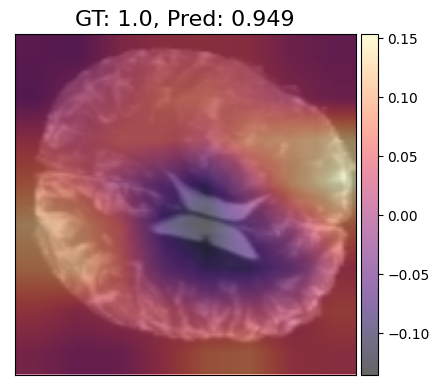

In [124]:
show_cam_one_batch(val_batch, preds=torch.unsqueeze(pred[0][1],0), cams=torch.unsqueeze(cam_map, 0))